<a href="https://colab.research.google.com/github/isabellacadisco/Algorithms-for-Massive-Data-course/blob/main/deep_learning_tutorial_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial neurons, feed-forward neural networks, convolutional neural networks, and deep learning

## with several citations to "Learn tensorflow without a PhD", by Martin Görner

(available at https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd)

## Build a handwritten digit recognizer

- More general problem: image classification
- Possible solution: machine learning
  - several examples (image, class)
  - induction process
  - classifier that maps generic image to class
- Among the possible ways: artificial neural networks

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from IPython.display import display, Javascript, clear_output, HTML
from google.colab import output
from PIL import Image
import io, base64
import PIL

print("Tensorflow version " + tf.__version__)

np.set_printoptions(precision=3, threshold=11)

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0') #, figsize=(16,9)
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__),
                                   "mpl-data/fonts/ttf")

Tensorflow version 2.9.2


## Artificial neural networks

- Inspired by the central nervous system
- (of which they represent a highly simplified model)
- Composed by (a lot of) artificial neurons (or units)

## The artificial neuron (unit)

- $x_1, \dots, x_n$: inputs,
- $w_1, \dots, w_n$: weights,
- $b$: bias,
- $\mathrm{logit} = \sum w_i x_i - b$
- $f: \mathbb R \mapsto \mathbb R$: activation function,
- output: $y = f(\mathrm{logit})$

![A very simple neuron](https://malchiodi.di.unimi.it/archive/deep-learning/simple-neuron.png)

## A slightly more complex unit

![A neuron recognizing digits](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/e218e6eee9da4e_1920.png)

[Source: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist]

Historically, this is known as a _perceptron_.

## Activation functions

- threshold

\begin{equation}
f(x) = \begin{cases}
       1 & \text{if $x \geq 0$,} \\
       0 & \text{otherwise.}
\end{cases}
\end{equation}

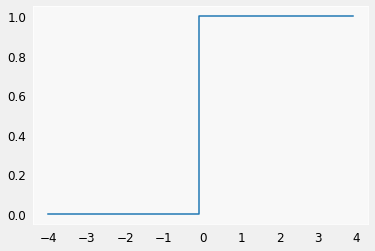

In [2]:
def threshold(x):
    return 1 if x >= 0 else 0

x = np.arange(-4, 4, 0.1)
y_threshold = list(map(threshold, x))
plt.step(x, y_threshold)
plt.show()

- sigmoid (continuous approximation of threshold)

\begin{equation}
f(x; \beta) = \frac{1}{1 + \mathrm{e}^{-\beta x}}
\end{equation}

In [3]:
def sigmoid(x, beta=1):
    return 1 / (1+math.exp(-beta * x))

def sigmoid_plot(beta):
    plt.plot(x, y_threshold)
    y_sigmoid = list(map(lambda x: sigmoid(beta, x), x))
    plt.plot(x, y_sigmoid, c='g')
    plt.show()

interact(sigmoid_plot,
         beta=widgets.FloatSlider(min=0.01,
                                  max=10,
                                  step=.1,
                                  value=1));

interactive(children=(FloatSlider(value=1.0, description='beta', max=10.0, min=0.01), Output()), _dom_classes=…

- hyperbolic tangent

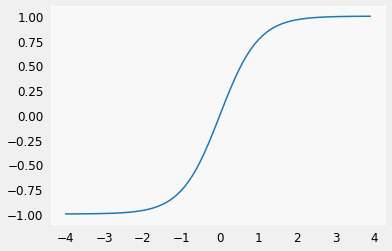

In [4]:
y_tanh = list(map(math.tanh, x))
plt.plot(x, y_tanh)
plt.show()

## Bring me data, labeled data!

In [5]:
BATCH_SIZE = 128
EPOCHS = 10

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

## Data organization

We will consider each time a _minibatch_ of 128 examples, selected using a _round-robin_ criterion.

In [6]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file,
                                                    28*28,
                                                    header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file,
                                                     1,
                                                     header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    
    # this small dataset can be entirely cached in RAM
    dataset = dataset.cache()  
    
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    # fetch next batches while training on the current one
    dataset = dataset.prefetch(AUTO)
    
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)

    # this small dataset can be entirely cached in RAM
    dataset = dataset.cache()

    # 10000 items in eval dataset, all in one batch
    dataset = dataset.batch(10000, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

In [7]:
for example in training_dataset.take(1):
  images, labels = example
  break
image, label = images[0], labels[0]
print(image.numpy())
print(image.numpy().shape)
print(label)

[0. 0. 0. ... 0. 0. 0.]
(784,)
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [8]:
image.numpy().reshape((28, 28))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

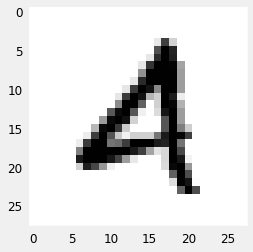

In [9]:
plt.imshow(1 - image.numpy().reshape((28, 28))/255, cmap=plt.get_cmap("gray"))
plt.show()

In [10]:
# pull a batch from the datasets.
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  for validation_digits, validation_labels in validation_dataset:
    validation_digits = validation_digits.numpy()
    validation_labels = validation_labels.numpy()
    break
  for training_digits, training_labels in batch_train_ds:
    training_digits = training_digits.numpy()
    training_labels = training_labels.numpy()
    break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []

  # format 'LA': black in channel 0, alpha in channel 1
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255))
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,
                                              'DejaVuSansMono-Oblique.ttf'),
                                 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,
                                              'STIXGeneral.ttf'),
                                 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10),
           fill=(255,255),
           font=font1 if i<10 else font2)

  # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits,
                                                        [28, 28*n]),
                                             n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display(fig)
  
# utility to display multiple rows of digits,
# sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n],
                   predictions[idx][i*n:(i+1)*n],
                   labels[idx][i*n:(i+1)*n],
                   '{} sample validation digits out of {} '
                   'with bad predictions in red and sorted '
                   'first'.format(n*lines, len(digits)) if i==0 else '', n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0],
                                                                      y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)


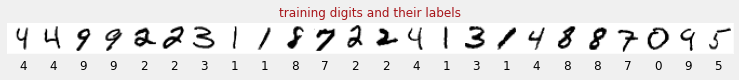

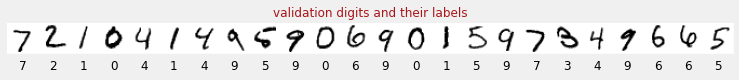

In [11]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

![A neuron recognizing digits](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/e218e6eee9da4e_1920.png)

[Source: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist]


$$ L = X \cdot W + b $$

<img src="https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/706248ddefae07f0.gif">

[Source: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/]

![](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/a49ddecea0ee8f52_1920.png)
![](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/ef0d98c0952c262d_1920.png)
![](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/d51252f75894479e.gif)

## How good is a unit?

* Maximize _accuracy_ (given several _targets_ $t^{(j)}$ and the corresponding _predictions_ $y^{(j)}$, measure how many times the prediction equals the target)
  
* In our case, $t, y \in [0, 1]^10$, thus we can measure accuracy as the cardinality of the set

$$ \left\{ j \text{ such that } \arg\max_{1 \leq i \leq 10} \left\{ t^{(j)}_i \right\} = \arg\max_{1 \leq i \leq 10} \left\{ y^{(j)}_i \right\} \right\}$$


* Alternatively, minimize Kullback-Leibler divergence, or cross-entropy: given two (discrete) probability distributions $\{ p_1, \dots, p_d \}$ and $\{ q_1, \dots, q_d \}$ over the same set, the following quantity measures how close the two distributions are:

$$ - \sum_{i} p_i \log \frac{q_i}{p_i} $$

* In our case, $\{p_1, \dots, p_{10}\}$ are the outputs of our neuron once an image has been fed in, and $t^{(j)}$, and $\{q_1, \dots, q_{10}\}$ are the components of the corresponding target, thus the cross-entropy value is

$$ \sum_j - \sum_{i} y^{(j)}_i \log \frac{t^{(j)}_i}{y^{(j)}_i} $$

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/6dbba1bce3cadc36.png">

[Source: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist]

In [12]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## How does this work?

Minimizing the loss function, either

- analytically, using calculus,
- pointwise, using _backpropagation_ on a _computation graph_.

![](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/9d3ab44f06bb0f7a_1920.png)

[Source: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist]

Concerning the first option, consider for instance a single-output neuron with sigmoidal activation function: let

- $x_1, \dots, x_n$ denote the inputs to the neuron;
- $w_1, \dots, w_n$ denote the corresponding connection weights,
- $\mathrm{logit}^{(j)} = \sum_i w_i x^{(j)}_i$ be the _signal_ arriving to the perceptron when the $j$-th example is presented;
- $y^{(j)} = f_\beta(\mathrm{logit}^{(j)})$ the output of the neuron when the $j$-th example is presented.

If we measure performance using the cumulated L2 loss (which is more appropriate in this case, since we have a single output)

$$E(w_1, \dots, w_n) = \frac{1}{2} \sum_j \left( t^{(j)} - y^{(j)} \right)^2,$$

it is easy to compute the derivatives of $E$ w.r.t. any $w_k$ using the chain rule:

$$
\frac{\partial E}{\partial w_k} = 
\frac{1}{2} \sum_j -2 \left( t^{(j)} - y^{(j)} \right)
\frac{\partial y^{(j)}}{\partial w_k}.
$$

Now, 

$$
\frac{\partial y^{(j)}}{\partial w_k} = f'_\beta(\mathrm{logit}^{(j)})
\frac{\partial \mathrm{logit}^{(j)}}{\partial w_k} =
f'_\beta(\mathrm{logit}^{(j)}) \frac{\partial}{\partial w_k}\sum_i w_i x^{(j)}_i =
f'_\beta(\mathrm{logit}^{(j)}) x^{(j)}_k
$$

Summing up,

$$
\frac{\partial E}{\partial w_k} = \sum_j \left( y^{(j)} - t^{(j)} \right)
f'_\beta(\mathrm{logit}^{(j)}) x^{(j)}_k,
$$

which in vectorial form reads

$$\nabla E(w) = \sum_j \left( y^{(j)} - t^{(j)} \right)
f'_\beta(\mathrm{logit}^{(j)}) x^{(j)}.
$$

Note also that the derivative of the sigmoidal activation is easily computed in terms of the original value $f_\beta(x)$, as

$$
f'_\beta(x) = \frac{\mathrm d}{\mathrm dx} \frac{1}{1 + \mathrm e^{-\beta x}}
= \frac{\beta \mathrm e^{-\beta x}}{\left( 1 + \mathrm e^{-\beta x} \right)^2}
= \beta \frac{1}{1 + \mathrm e^{-\beta x}} \left( 1 - \frac{1}{1 + \mathrm e^{-\beta x}} \right)
= \beta f_\beta(x) (1 - f_\beta(x))
$$

This means that $f'_\beta(\mathrm{logit}^{(j)}) = \beta f_\beta(\mathrm{logit}^{(j)})(1 - (\mathrm{logit}^{(j)})) = \beta y^{(j)} (1 - y^{(j)})$, so that

$$\nabla E(w) = \sum_j \left( y^{(j)} - t^{(j)} \right)
\beta y^{(j)} (1 - y^{(j)}) x^{(j)}.$$

Note that this approach would require to compute anew the analytical form of gradient each time we change anything in the perceptron structure (e.g., use a different activation function). In the code here below we rely on the second alternative, namely computing the value of the gradient only in correspondence of points actually needed during the optimization process, and this will be done using a technique called _backpropagation_, which we will detail later on.

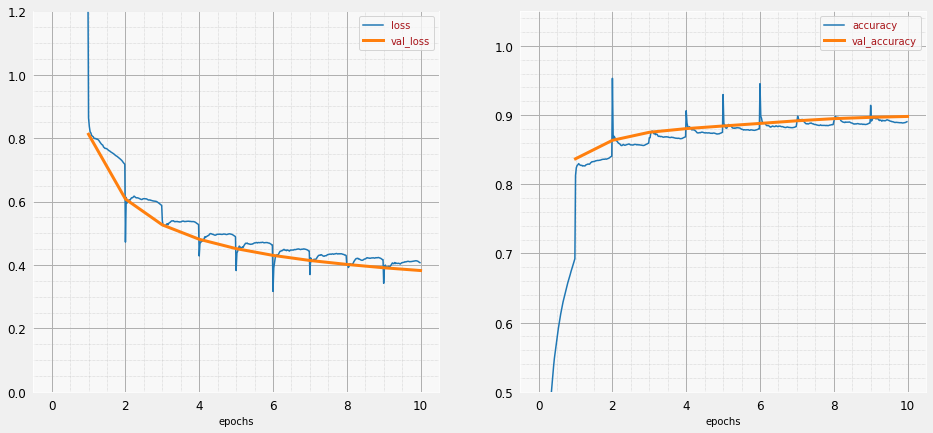

468/468 [==============================] - 4s 8ms/step - loss: 0.4070 - accuracy: 0.8905 - val_loss: 0.3824 - val_accuracy: 0.8980


In [13]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training])

## Deep learning (aka multilayer perceptron)

<img src="https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/fba0638cc213a29_1920.png" width="80%">

In [14]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='sigmoid'),
      tf.keras.layers.Dense(60, activation='sigmoid'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 200)               157000    
                                                                 
 dense_2 (Dense)             (None, 60)                12060     
                                                                 
 dense_3 (Dense)             (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


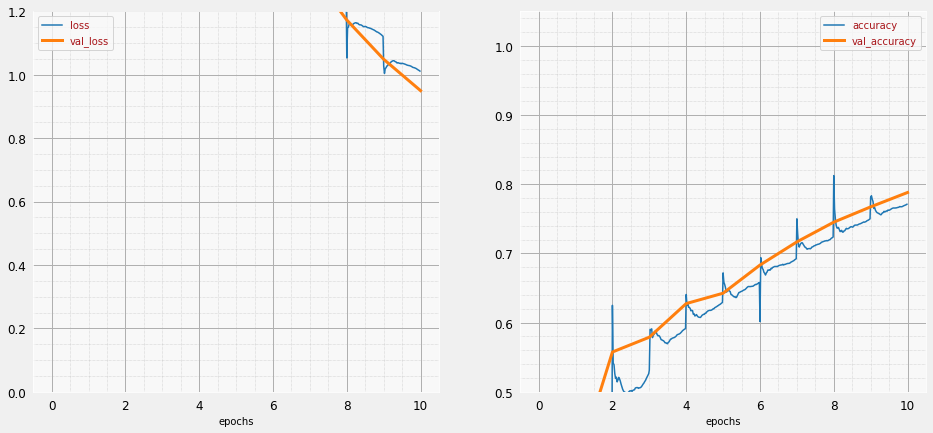

468/468 [==============================] - 3s 7ms/step - loss: 1.0101 - accuracy: 0.7717 - val_loss: 0.9497 - val_accuracy: 0.7881


In [15]:
training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training])

See nothing? Check out loss and accuracy values vs Y-axes

## From sigmoid to ReLu

Vanishing gradient problem!

![](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/29151b846e13320d.png)

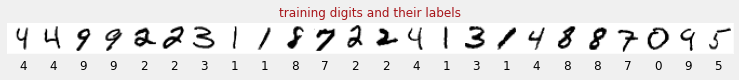

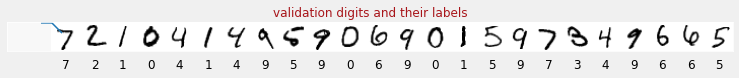

In [16]:
def relu(x):
    return max(0, x)

x_vals = np.arange(-10, 10, .5)
plt.plot(x_vals, list(map(relu, x_vals)))
plt.show()

Derivative of relu in 0? Either fix a value or use _softplus_

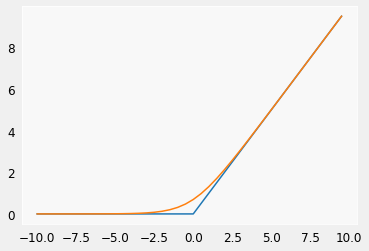

In [17]:
def softplus(x):
    return  math.log(1.0 + math.e**x)

plt.plot(x_vals, list(map(relu, x_vals)))
plt.plot(x_vals, list(map(softplus, x_vals)))
plt.show()

(by the way, note that $\mathrm{softplus}'(x)=\mathrm{sigmoid}(x)$)


We will also switch to a more efficient optimizer: ADAM

In [18]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               157000    
                                                                 
 dense_5 (Dense)             (None, 60)                12060     
                                                                 
 dense_6 (Dense)             (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


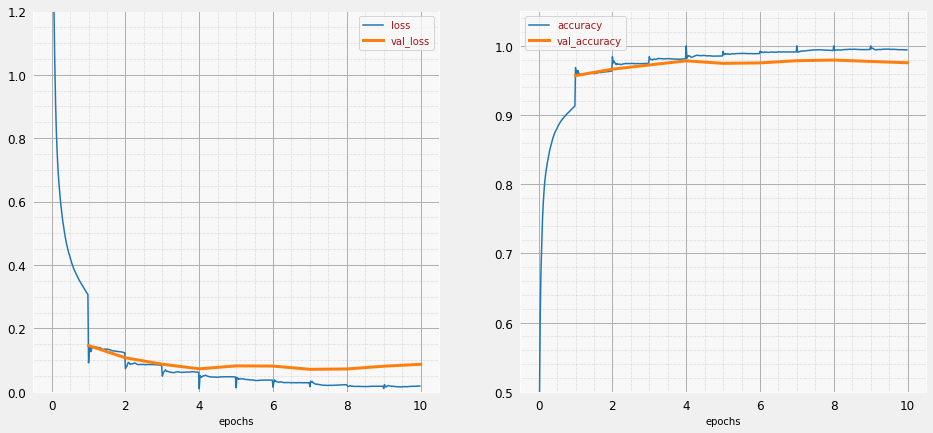

468/468 [==============================] - 4s 8ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0867 - val_accuracy: 0.9756


In [19]:
training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training])

## Let's go faster!

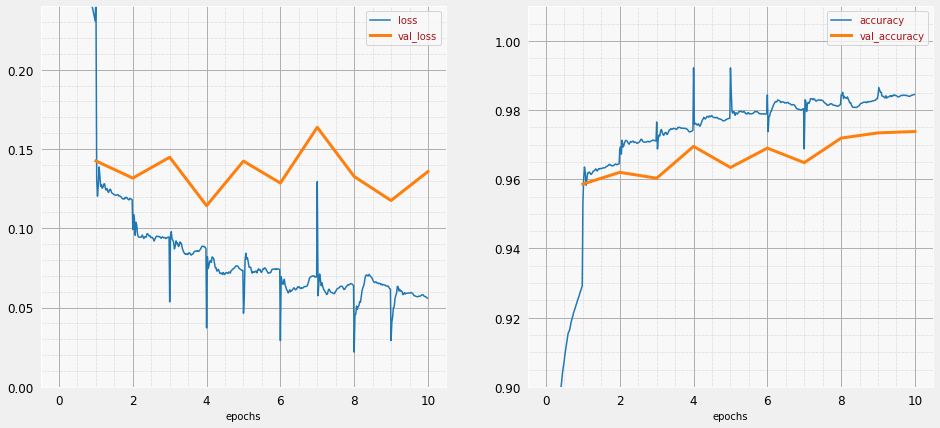

468/468 [==============================] - 4s 8ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.1358 - val_accuracy: 0.9738


In [21]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

#same number of epochs, worst than before
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), #here (=! from before) im specifying the learning rate, instance of customize optimizer, increasing lr instabilities (jumps in graphs)
              loss='categorical_crossentropy', #each time i reach integer number starting a new epoch, reconsidering previously processed data, network may be not so good, higer lr less stable trajectory
              metrics=['accuracy'])

training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

plot_training = PlotTraining(sample_rate=10, zoom=5)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training])

## OK, not so fast

<ipython-input-10-b3934429e98b>:78: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.arange(epochs+1, dtype=np.float)


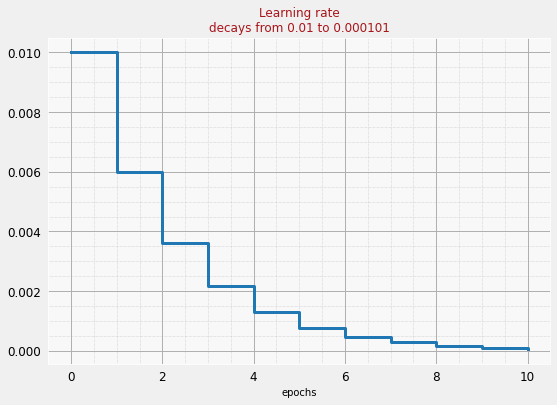

In [22]:
# CALLBACK (eg button click)

# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

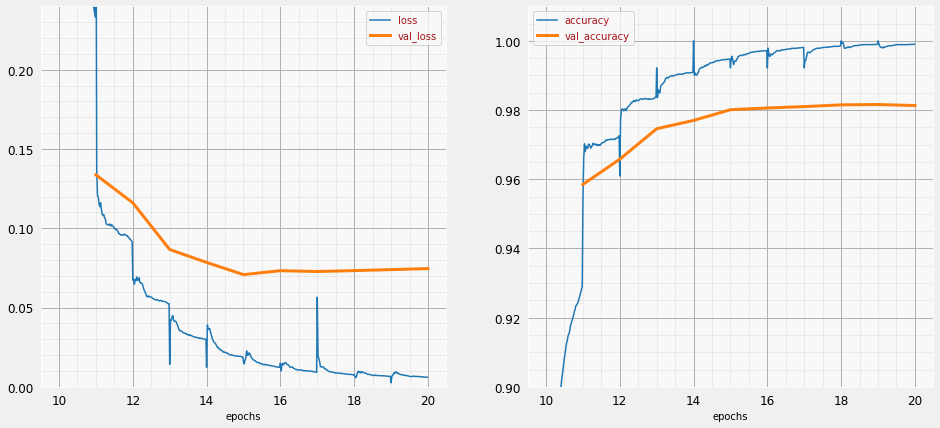

468/468 [==============================] - 4s 8ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0746 - val_accuracy: 0.9813 - lr: 1.0078e-04


In [23]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback]) #adapt learning rate here!

#1st graph: validation loss after 14th epoch starts to increase, network very goog w/ data for training but not good with unseen data

#what we can do?
#smaller lr
#deeper network

## Why not trying a deeper net?

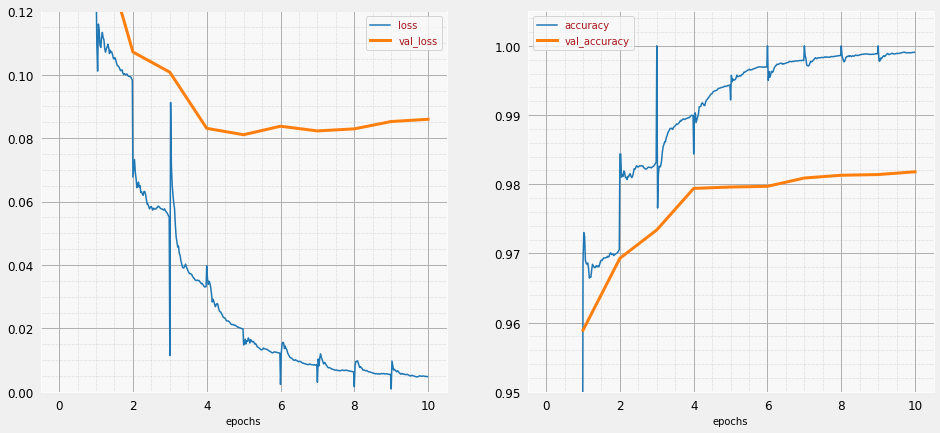

468/468 [==============================] - 8s 16ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0859 - val_accuracy: 0.9818 - lr: 1.0078e-04


In [24]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=10, zoom=10)

training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

## That's overfitting!

## Regularization: dropout

<img src="https://lh4.googleusercontent.com/La8YMod1QGZtaDyYw1EjKpj5UbD1TFPpDMOjObk0o8Y_QQVtxIrPKlFkT63cWwElgko1D03UuaRFyDQ-xHgyr5P99k0J5Lsxec6HC9BHRFYyqb8whYD6LJjlyoBA5aZDQ84z-UfVNA" width="60%">

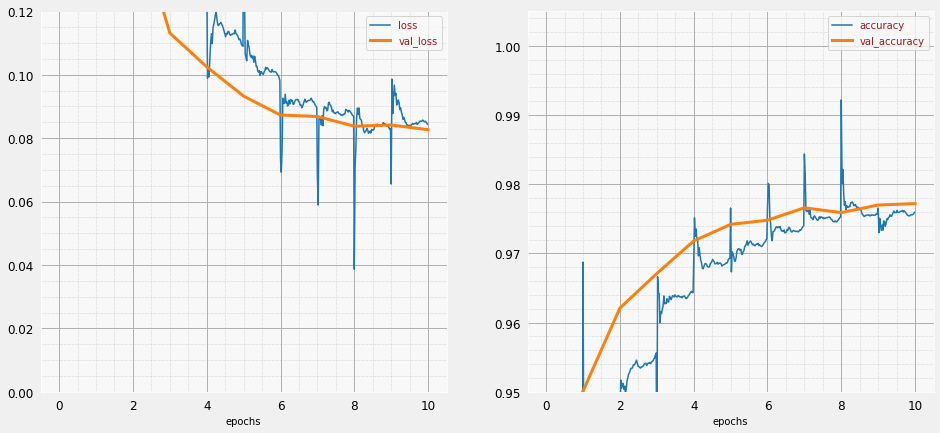

468/468 [==============================] - 4s 9ms/step - loss: 0.0842 - accuracy: 0.9760 - val_loss: 0.0827 - val_accuracy: 0.9772 - lr: 1.0078e-04


In [26]:
#regularization techniques to avoid overfitting

#add to loss function a term= sum of squares of the weight

#other tech, better results: DROP OUT
# backpropagation algo:
# 1 ex presented to network, 
# 2 on the basis of comparison output-actual label, retropropagated

#metaphorically remove some neurons from nn, chosen at random

# CAN MIMIC DROP OUT ADDING LAYERS TO NETWORKS

model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.25),                 #PLACE PARTICULAR LAYER FOR DORP OUT, 0.25 = p(not being considered) at each iteration or each node
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=10, zoom=10)

training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])


#result not so good but at least don't have overfitting
# introduce CNN

## Not really worked, yeah?

## Convolutional networks

![Convolution](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/ca8f34f3d28ea528.gif)

![Used convolutional network](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/d1b557707bcd1cb9_1920.png)

![](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/2b2d4263bb8470b.gif)

![](https://codelabs.developers.google.com/static/codelabs/cloud-tensorflow-mnist/img/a44aa392c7b0e32a_1920.png)

## The used CNN

![The used CNN](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/e1a214a170957da1.png)

In [27]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)), # inpout layer, match original images 
   
      #original shape 28*28, reshape
      
      # to add conv layer Conv2D
   
      #kernel size = size of window

      #padding = same -> perform as not change dimension
      

      tf.keras.layers.Conv2D(kernel_size=3, filters=12, # from 3x3 window -> 12 filters, using padding cause number of neurons x, y the same
                             activation='relu', padding='same'),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, #enlarge window
                             activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32,
                             activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(), #then flatten
      tf.keras.layers.Dense(200, activation='relu'), #add dense layer
      tf.keras.layers.Dense(10, activation='softmax') #finish with softmax
  ])


#still sequential, still stucking layers
# not using class input for input layer, dataset already modified to be one dimentional

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 12)        120       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 24)        10392     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          27680     
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense_28 (Dense)            (None, 200)               313800    
                                                                 
 dense_29 (Dense)            (None, 10)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


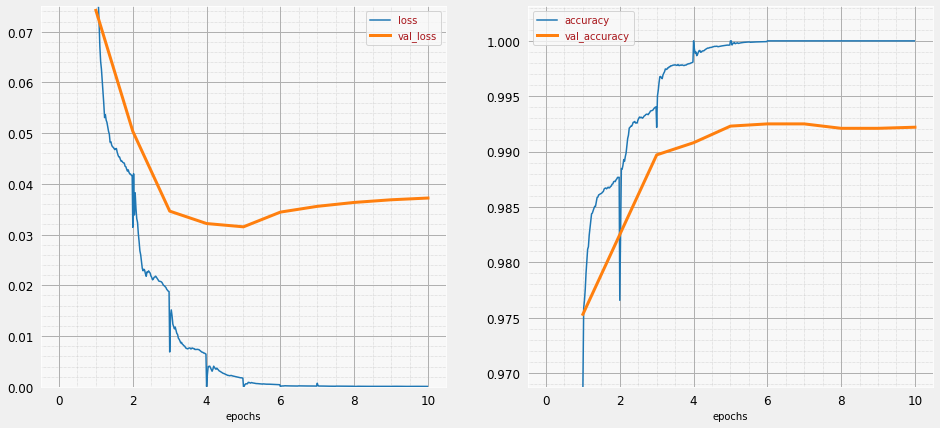

468/468 [==============================] - 7s 16ms/step - loss: 7.9223e-05 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 0.9922 - lr: 1.0078e-04


In [28]:
training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

## Let's see predictions, instead of loss/accuracy!

1/1 [==============================] - 0s 141ms/step


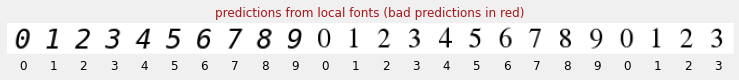

1/1 [==============================] - 0s 105ms/step


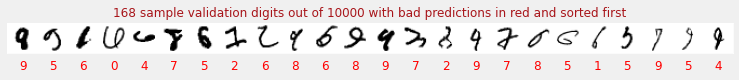

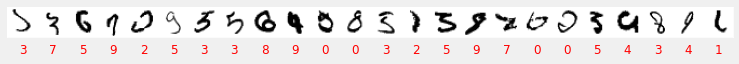

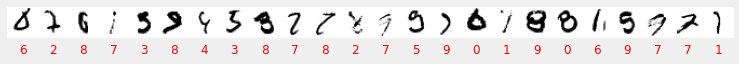

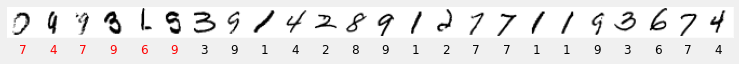

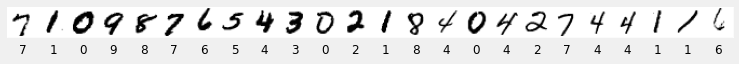

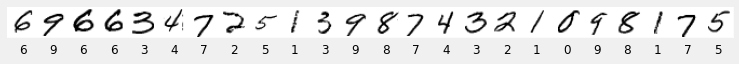

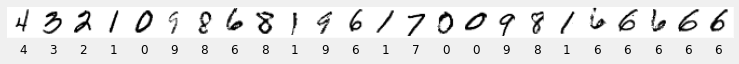

In [29]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels,
               font_labels,
               'predictions from local fonts (bad predictions in red)', N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels,
                         validation_labels, N, 7)

## Let's add dropout again

In [30]:
#avoid add drop uot in conv layer


model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(kernel_size=3, filters=12,
                             activation='relu', padding='same'),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24,
                             activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32,
                             activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.4), #AADED JUST IN CONNECTION DENSE - DENSE
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 12)        120       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 24)        10392     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          27680     
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_30 (Dense)            (None, 200)               313800    
                                                                 
 dropout_6 (Dropout)         (None, 200)             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


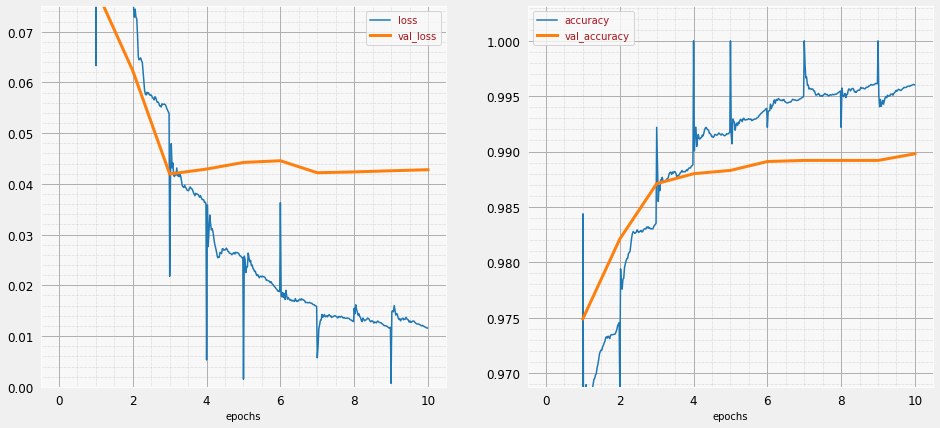

468/468 [==============================] - 7s 14ms/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.0428 - val_accuracy: 0.9898 - lr: 1.0078e-04


In [31]:
training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

## Batch normalization

![](https://lh5.googleusercontent.com/zmr3jO6E-N5hGCeor77HnMAv4mLn4XM4wHnVFGBkdXg_An-zc98Elxx5WpyzizAxl6s1uf6WY246mUjosC8bR75lf2MELcLPRT_StiNWZ3CCnQj4KMyu7dgv__PHLaHoKoQ71waRyQ)

![](https://lh4.googleusercontent.com/elT17KcIiCOqDJ6qhIJv4Szn6UNA0x-Rgt5S04msp4ge6mRWaD-SKp0ks9bnEl-bbYc_NGfzL77c9CGxneE23jaY5BLsLo0JP63lIMTygBK3LQAFYNJv64qDgkaIEVnhuiAZwBlkmQ)

![](https://lh4.googleusercontent.com/10YpnDuAXOuDbBFhR0YzIL9tko_9JcACgBZI_gq7lKE1qCDeRr75b4pcJv5Ucl6GQqcmk9Vv_2z8lo8qv2X6l139v5T0yhgxHKhwDyEBC5sq7PbAcfjXBdj7Z02trb5pl22wzZE9hQ)

In [32]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12,
                             use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24,
                             use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32,
                             use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False), #batch norm alreasy take sin charge something that is equivalent to thereshold, the shifthing part
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 12)        108       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 12)       36        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 12)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 24)        10368     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 24)       72        
 hNormalization)                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


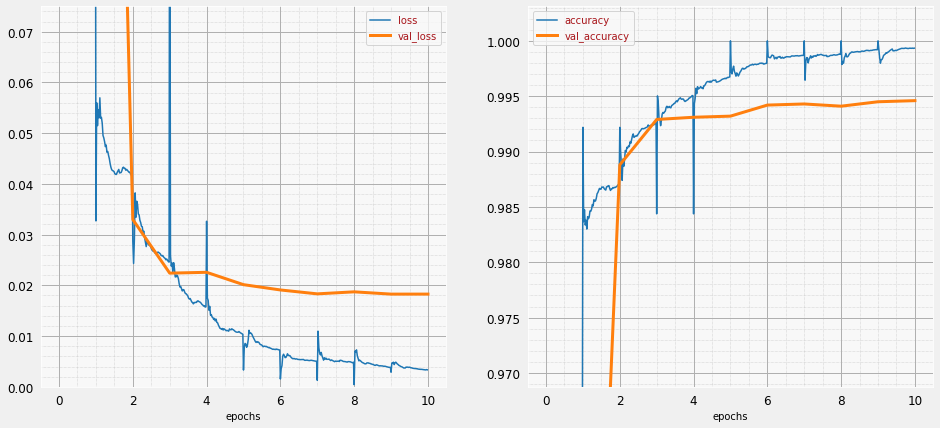

468/468 [==============================] - 5s 11ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0183 - val_accuracy: 0.9946 - lr: 1.0078e-04


In [33]:
training_dataset = get_training_dataset(training_images_file,
                                        training_labels_file,
                                        BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file,
                                            validation_labels_file)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

1/1 [==============================] - 0s 108ms/step


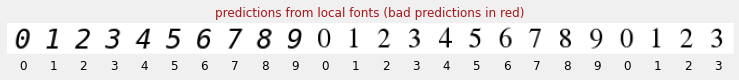

1/1 [==============================] - 0s 125ms/step


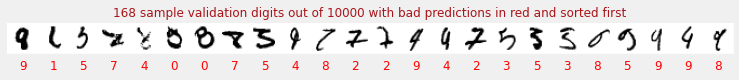

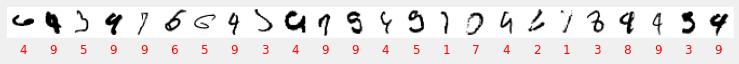

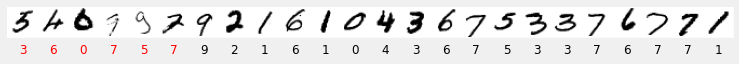

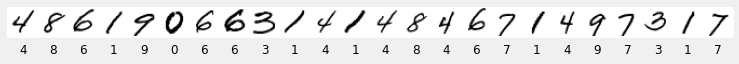

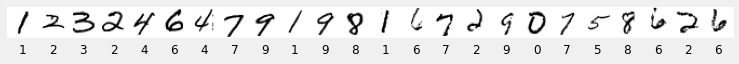

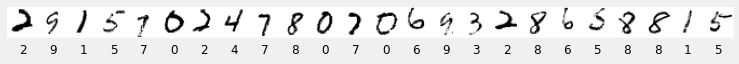

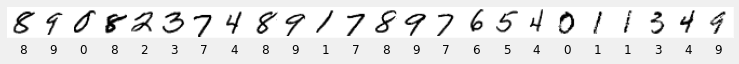

In [34]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels,
               'predictions from local fonts (bad predictions in red)', N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels,
                         validation_labels, N, 7)

<IPython.core.display.Javascript object>

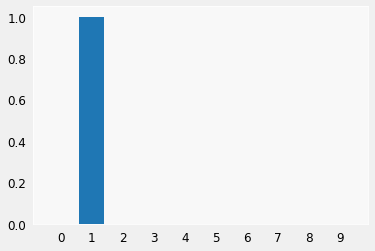

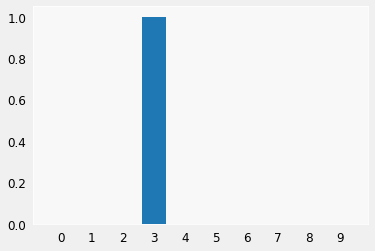

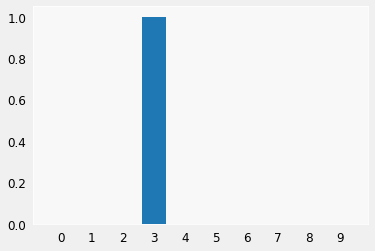

In [ ]:
#codice per aggiungere la scrittuta manuale di digit su schermo 


base_html='''
<div id="canvasDiv-{0}" style="float: left; margin-right: 2em;"></div>
<div id="resultDiv-{0}"></div>
<div style="clear: both;">
<button id="button" onClick="get_image_{0}()">Classify</button>
<button onClick="clear_image()">Clear canvas</button>
</div>
'''

base_js='''
const div = document.getElementById('canvasDiv-{0}');
canvas = document.createElement('canvas');
canvas.setAttribute('width', 200);
canvas.setAttribute('height', 200);
canvas.setAttribute('id', 'canvas-{0}');
canvas.setAttribute('style', 'border: 1px solid black; heigth: 5em;');
div.appendChild(canvas);
if(typeof G_vmlCanvasManager != 'undefined') {
    canvas = G_vmlCanvasManager.initElement(canvas);
}

context = canvas.getContext("2d");

function getMousePos(canvas, e) {
    var rect = canvas.getBoundingClientRect();
    return { x: e.clientX - rect.left, y: e.clientY - rect.top };
};

canvas.addEventListener('mousedown', function(e){
    var pos = getMousePos(canvas, e);
    var mouseX = pos.x;
    var mouseY = pos.y;

    paint = true;
    addClick(mouseX, mouseY);
    redraw();
});


canvas.addEventListener('mousemove', function(e){
    if(paint){
        var pos = getMousePos(canvas, e);
        var mouseX = pos.x;
        var mouseY = pos.y;
        addClick(mouseX, mouseY, true);
        redraw();
    }
});

canvas.addEventListener('mouseup', function(e){
    paint = false;
});

canvas.addEventListener('mouseleave', function(e){
    paint = false;
});


var clickX = new Array();
var clickY = new Array();
var clickDrag = new Array();
var paint;


function addClick(x, y, dragging)
{
    clickX.push(x);
    clickY.push(y);
    clickDrag.push(dragging);
}

function redraw(){
    context.clearRect(0, 0, context.canvas.width, context.canvas.height);
  
    context.strokeStyle = "#111111";
    context.lineJoin = "round";
    context.lineWidth = 13;

    for(var i=0; i < clickX.length; i++) {
        context.beginPath();
        if(clickDrag[i] && i){
            context.moveTo(clickX[i-1], clickY[i-1]);
        }else{
            context.moveTo(clickX[i]-1, clickY[i]);
        }
        context.lineTo(clickX[i], clickY[i]);
        context.closePath();
        context.stroke();
    }
}

function callback(msg){
  console.log(msg);
  res = msg.content.data["text/plain"];
  document.getElementById("resultDiv-{0}").innerHTML = res.substr(1, res.length-2);
  console.log(res);
}


function get_image_{0}() {
    console.log('in get_image_{0}');
    var canvas = document.getElementById('canvas-{0}');
    var ctx = canvas.getContext('2d');
    image_url = canvas.toDataURL();
    console.log(image_url);
};


function clear_image() {
    context.clearRect(0, 0, context.canvas.width, context.canvas.height);
    clickX = new Array();
    clickY = new Array();
    clickDrag = new Array();
};


document.querySelector('#button').onclick = () => {
        google.colab.kernel.invokeFunction('notebook.classify', [canvas.toDataURL()], {});
      };

'''

display(HTML(base_html.replace('{0}', 'pp')))
display(Javascript(base_js.replace('{0}', 'pp')))

def classify(data):

  im = Image.open(io.BytesIO(base64.b64decode(data.split(',')[1])))
  im_28x28 = im.convert('L').resize([28, 28]) #, resample=PIL.Image.ANTIALIAS)
  
  im_flat = list(im_28x28.getdata())
  result = model.predict([im_flat])
  
  #clear_output()
  plt.bar(range(10), result[0])
  plt.xticks(range(10))
  plt.show()


output.register_callback('notebook.classify', classify)